In [2]:
import os
import numpy as np
import xarray as xr

from scripts import mapOutputs2D as mout

import matplotlib.pyplot as plt
%matplotlib inline

**This example illustrates the effect of increasing time step length on the resulting landscape evolution.**

#### Mesh creation

In this example, we use the same mesh as the one defined in the `generate_mesh` folder. The initial surface consists of a flat triangulated squared grid (with noise) with 100 km sides and 200 m resolution

It defines a flat elevation at 200 m (with noise) and a simple tectonic uplift (with a linear slope ranging to 5 mm/yr). 

The goSPL input file (`gospl_mesh.npz`) has been copied in the `data` folder. Below we provide the code needed to regenerate it if necessary.

In [2]:
make_mesh = False
if make_mesh:
    
    import meshio
    import meshplex
    import uxarray as uxr
    from scripts import umeshFcts as ufcts

    dx = 200 # desired resolution
    nx = 501 # desired number of nodes along the x-axis
    ny = 501 # desired number of nodes along the y-axis

    tmin = 0.
    tmax = 0.005

    xcoords = np.arange(nx)*float(dx) 
    ycoords = np.arange(ny)*float(dx) 
    tecx = np.interp(xcoords, [xcoords[0],xcoords[-1]], [tmin,tmax])
    tec = np.broadcast_to(tecx, (nx, nx))[:ny,:]


    noise = np.random.normal(0, 0.05, tec.shape)
    elev = noise+100.

    ds = xr.Dataset({
        'elev': xr.DataArray(
                    data   = elev,
                    dims   = ['y','x'],
                    coords = {'x': xcoords,'y': ycoords},
                    ),
        'tec': xr.DataArray(
                    data   = tec,
                    dims   = ['y','x'],
                    coords = {'x': xcoords,'y': ycoords},
                    )
            }
        )
    ds['cellwidth'] = (['y','x'],dx*np.ones( (ny, nx)))


    output_path = "slope_tec" 
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    # Build your planar mesh
    ufcts.planarMesh(ds,output_path,fvtk='planar.vtk',fumpas=True,voro=True)

    # Loading the UGRID file
    ufile = output_path+'/base2D.nc'
    var_name = 'data'
    ugrid = uxr.open_grid(ufile) 

    # Perform the interpolation (bilinear) 
    ufcts.inter2UGRID(ds[['elev','tec']],ugrid,output_path,var_name,type='face',latlon=False)
    # ufcts.inter2UGRID(ds[['t']],ugrid,output_path,var_name,type='face',latlon=False)

    data_file = [output_path+'/'+var_name+'.nc']
    # Get the information related to the mesh: primal and dual mesh
    primal_mesh = uxr.open_dataset(ufile, *data_file, use_dual=False)
    dual_mesh = uxr.open_dataset(ufile, *data_file, use_dual=True)

    # Extract nodes and faces information
    ucoords = np.empty((dual_mesh.uxgrid.n_node,3))
    ucoords[:,0] = dual_mesh.uxgrid.node_x.values
    ucoords[:,1] = dual_mesh.uxgrid.node_y.values
    ucoords[:,2] = dual_mesh.uxgrid.node_z.values
    ufaces = primal_mesh.uxgrid.node_face_connectivity.values

    # Get information about your mesh:
    print("Number of nodes: ",len(ucoords)," | number of faces ",len(ufaces))
    edge_min = np.round(dual_mesh.uxgrid.edge_node_distances.min().values/1000.+0.,2)
    edge_max = np.round(dual_mesh.uxgrid.edge_node_distances.max().values/1000.+0.,2)
    edge_mean = np.round(dual_mesh.uxgrid.edge_node_distances.mean().values/1000.+0.,2)
    print("edge range (km): min ",edge_min," | max ",edge_max," | mean ",edge_mean)

    mesh = meshio.read(output_path+'/planar.vtk')
    vertex = mesh.points
    cells = mesh.cells[1][:][1]
    Umesh = meshplex.MeshTri(vertex, cells)
    Uarea = Umesh.control_volumes
    print('Cell area (km2): ',Uarea.min()*1.e-6,Uarea.max()*1.e-6)

    meshname = "data/gospl_mesh"
    np.savez_compressed(meshname, v=vertex, c=cells, 
                    z=primal_mesh.elev.data, t=primal_mesh.tec.data
                    )


You will find a series of goSPL input files:
- input-500.yml
- input-1.25k.yml
- input-2.5k.yml
- input-5k.yml

These files use the same elevation and forcing conditions, the only difference being the time step used to solve the stream power equation (ranging from 500 yrs to 5,000 years).

The surface is exposed to an uniform precipitation regime of 1 m/yr and is uplifted linearly from its fixed western side to the eastern one that experiences an uplift of 5 mm/yr. 

The value of the bedrock erodibility parameter K is set to 2e-4 in order to reach steady state during the simulated 1.e5 years. The model is purely erosional and therefore marine sedimentation is not considered. In addition, hillslope processes are also turned off, meaning that this example only relies on the implicit parallel flow discharge (using a single flow direction approach) and erosion equations.

In both cases the implicit schemas converge for the chosen solver and preconditioner (i.e. Richardson with block Jacobian).


## Running the simulations

To run the different simulations, you will need to do the following in a terminal:

```bash
mpirun -np X python3 runModel.py -i input-XX.yml 
```

where X is the number of processors to use (for example 5), and XX is the time step based on the input file name (for example 1k)

## Visualising the outputs

You can visualise the outputs of your simulations directly in Paraview. Below we also show how this could be extracted as netcdf grids and analysed in Python.


To do so, we will be using the `mapOutputs` Python class (available in the `scripts` folder) to first extract the outputs, remap the unstructured variables on a structured mesh. The class is also performing additional calculations on the dataset to extract individual catchments based on flow accumulation and elevation.

The interpolated model's variables are then exported as `netCDF` files, and each of them contains the following (if available from the simulation):

+ elevation `elevation` (m)
+ cumulative erosion/deposition `erodep` (m)
+ erosion/deposition rate `erodep_rate` (m/yr)
+ water flux discharge (accounting for lakes) `fillDischarge`(m3/yr)
+ sediment flux in rivers `sedimentLoad` (m3/yr)
+ main basin ids `basinID` (integer)
+ rainfall `precipitation` (m/yr)
+ tectonic `uplift` (m/yr)
+ cumulative flexural isostasy `flex` (m)

In [113]:
# Define output folder name for the simulation
out_path = 'results/'

if not os.path.exists(out_path):
    os.makedirs(out_path)
    
# The step corresponds to the output we want to generate, here we chose 10 as an example
stp = 10

# Name of each netcdf output file
ncout = os.path.join(out_path, "500yr_stp")

# Initialisation of the class
grid500 = mout.mapOutputs(path='./', filename='input-500.yml', step=stp, 
                       uplift=True, flex=False, model="utm")

# Remap the variables on the regular mesh using distance weighting interpolation
grid500.buildUTMmesh(res=200., nghb=4, smth=0.5)

# Export corresponding regular mesh variables as netCDF file
grid500.exportNetCDF(ncfile = ncout+str(stp)+'.nc')

Similarly we extract the grids for the other simulations:

In [114]:
# 1k simulation
ncout = os.path.join(out_path, "1.25ky_stp")
grid1k = mout.mapOutputs(path='./', filename='input-1.25k.yml', step=stp, 
                       uplift=True, flex=False, model="utm")
grid1k.buildUTMmesh(res=200., nghb=4, smth=0.5)
grid1k.exportNetCDF(ncfile = ncout+str(stp)+'.nc')

# 2.5k simulation
ncout = os.path.join(out_path, "2.5ky_stp")
grid10k = mout.mapOutputs(path='./', filename='input-2.5k.yml', step=stp, 
                       uplift=True, flex=False, model="utm")
grid10k.buildUTMmesh(res=200., nghb=4, smth=0.5)
grid10k.exportNetCDF(ncfile = ncout+str(stp)+'.nc')

# 5k simulation
ncout = os.path.join(out_path, "5ky_stp")
grid5k = mout.mapOutputs(path='./', filename='input-5k.yml', step=stp, 
                       uplift=True, flex=False, model="utm")
grid5k.buildUTMmesh(res=200., nghb=4, smth=0.5)
grid5k.exportNetCDF(ncfile = ncout+str(stp)+'.nc')


To extract the information for each time step, we do:

In [121]:
def getOutputs(finput,ncout,maxstp,res):

    grid = mout.mapOutputs(path='./', filename=finput, step=0, 
                        uplift=True, flex=False, model="utm")
    grid.buildUTMmesh(res=res, nghb=4, smth=0.)
    grid.exportNetCDF(ncfile = ncout+str(0)+'.nc')
    for k in range(0, maxstp+1):
        if k>0:
            grid.getData(k)
        grid.buildUTMmesh(res=res, nghb=4, smth=0.)
        grid.exportNetCDF(ncfile = ncout+str(k)+'.nc')

    return

In [122]:
getOutputs('input-500.yml',os.path.join(out_path, "500yr_stp"),40,200)

getOutputs('input-1.25k.yml',os.path.join(out_path, "1.25ky_stp"),40,200)

getOutputs('input-2.5k.yml',os.path.join(out_path, "2.5ky_stp"),40,200)

getOutputs('input-5k.yml',os.path.join(out_path, "5ky_stp"),20,200)

We can visualise a specific output 

In [3]:
sim1 = xr.open_dataset("results/500yr_stp40.nc")
sim2 = xr.open_dataset("results/1.25ky_stp40.nc")
sim3 = xr.open_dataset("results/2.5ky_stp40.nc")
sim4 = xr.open_dataset("results/5ky_stp20.nc")

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_4010/2016511208.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


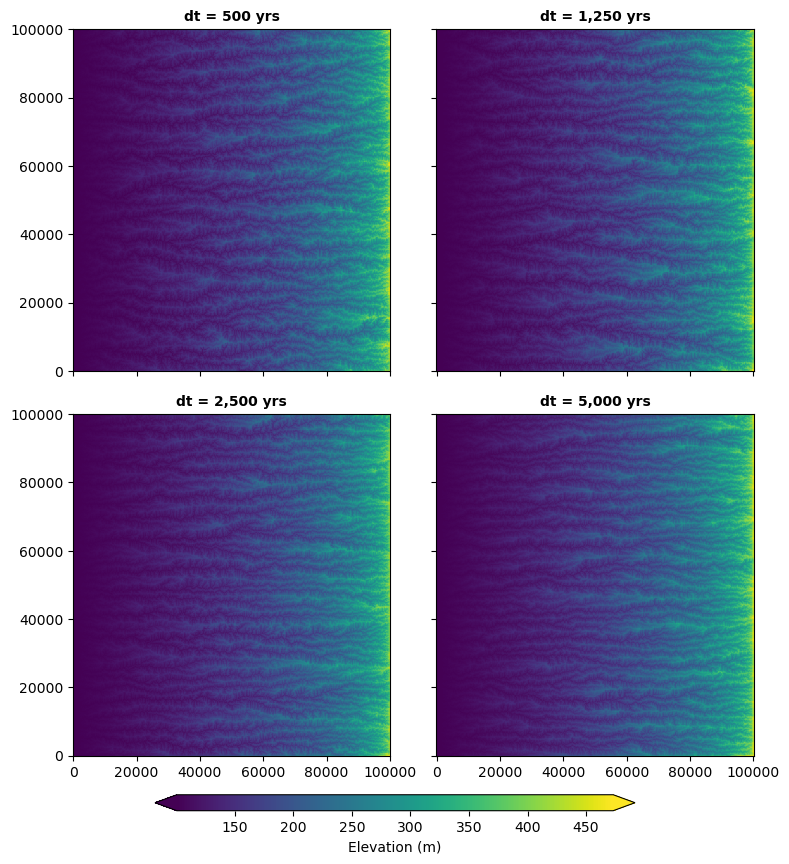

In [4]:
fig, axs = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
sim1.elevation.plot(ax=axs[0,0], add_labels=False, add_colorbar=False)
sim2.elevation.plot(ax=axs[0,1], add_labels=False, add_colorbar=False)
sim3.elevation.plot(ax=axs[1,0], add_labels=False, add_colorbar=False)
im = sim4.elevation.plot(ax=axs[1,1], add_labels=False, add_colorbar=False)

axs[0,0].set_title('dt = 500 yrs', fontsize=10, fontweight="bold")
axs[0,1].set_title('dt = 1,250 yrs', fontsize=10, fontweight="bold")
axs[1,0].set_title('dt = 2,500 yrs', fontsize=10, fontweight="bold")
axs[1,1].set_title('dt = 5,000 yrs', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.02, 0.6, 0.02]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Elevation (m)')

plt.tight_layout()
plt.show()

In [5]:
maxelev = np.zeros(4)
maxelev[0] = sim1.elevation.max().data+0.
maxelev[1] = sim2.elevation.max().data+0.
maxelev[2] = sim3.elevation.max().data+0.
maxelev[3] = sim4.elevation.max().data+0.

print('Average max. elevation between the different simulation: %0.2f m'%maxelev.mean())
print('Standard deviation: %0.2f m'%maxelev.std())

Average max. elevation between the different simulation: 462.99 m
Standard deviation: 13.32 m


Extracting mean elevation through time:

In [7]:
out_path = 'results/'
def get_mean_elevation(ncout, maxtsp):
    mean_z = []
    for k in range(maxtsp+1):
        ds = xr.open_dataset(ncout+str(k)+".nc")
        mean_z.append(ds.elevation.mean().data+0.)
    return mean_z

mean1 = get_mean_elevation(os.path.join(out_path, "500yr_stp"), 40)
mean2 = get_mean_elevation(os.path.join(out_path, "1.25ky_stp"), 40)
mean3 = get_mean_elevation(os.path.join(out_path, "2.5ky_stp"), 40)
mean4 = get_mean_elevation(os.path.join(out_path, "5ky_stp"), 20) 

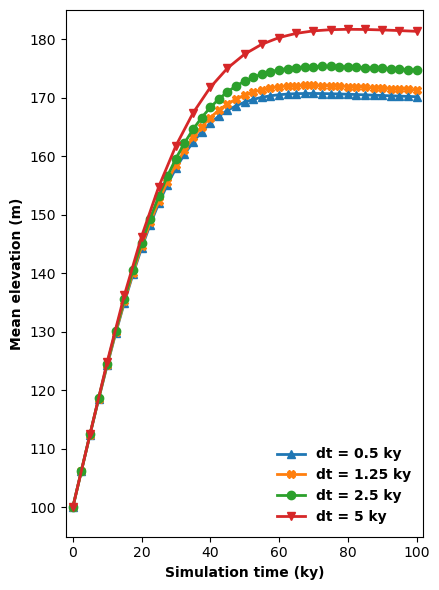

In [10]:
time1 = np.arange(41)*2.5e3
time2 = np.arange(21)*5.e3

fig, ax = plt.subplots(1,1, figsize=(4.5,6))
plt.plot(time1/1000, mean1, label='dt = 0.5 ky', marker='^', lw=2)
plt.plot(time1/1000, mean2, label='dt = 1.25 ky', marker='X', lw=2)
plt.plot(time1/1000, mean3, label='dt = 2.5 ky', marker='o', lw=2)
plt.plot(time2/1000, mean4, label='dt = 5 ky', marker='v', lw=2)

ax.legend(loc=4, frameon=False, fontsize=8, prop={'weight':'bold'})
plt.xlabel("Simulation time (ky)", fontsize=10, fontweight="bold")
plt.ylabel("Mean elevation (m)", fontsize=10, fontweight="bold")

plt.axis([-2, 102, 95, 185])

plt.tight_layout()
plt.show()

**The solutions for the mean landscape elevation show that the landscape reaches steady state in all cases, and overall the final elevations are in good agreement with a maximum elevation of 463±13 m.** 

Yet as the time step increases the differences between models increase over time. By the end of the simulation, the mean elevation difference between the case with Δt equals 500 years and the one at 5,000 years is around 6.5 %, whereas the difference with a Δt of 1250 years is below 1 %. It illustrates the transient nature of the landscape and its strong dependence on antecedent morphologies. Even small changes in elevation could potentially trigger completely different landscape features. 

> Compared to the explicit algorithm, the approach here relies on an implicit schema and produces a more stable solution for longer timescales. Yet time step limitations are still required to ensure a good representation of landscape features (e.g. knickpoint propagation) and care should be taken when choosing a given simulation time step.

The iterative linear solvers of the implicit methods for both flow accumulation and erosion use previous time step solution as an initial guess. In cases in which the landscape does not change significantly between consecutive time steps, both the flow accumulation and erosion rates are likely to remain almost unchanged and the number of iterations required by the solver to reach convergence will be small. As an example, if the drainage network remains the same between two iterations, the flow accumulation solver solution will be obtained immediately and the results given directly. It highlights a second implication of the choice of time step. Not only does the time step influence the final landscape morphology, but it also controls the model running time. In some cases, similar running times will be achieved with smaller time steps if solver solutions are obtained in a reduced number of iterations.